In [1]:
from algorithm import *
from model import *
import torch
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import pickle
from netrd.distance import netsimile
import networkx as nx
import os.path as osp
from scipy.sparse import coo_matrix
from tqdm import tqdm
import random
import warnings
from torch.optim import Adam
from utils import *
import argparse
warnings.filterwarnings("ignore")

In [2]:
# import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

In [3]:
def load_adj(dataset):
    if (dataset == "celegans"):
        S = torch.load("data/celegans.pt")
    elif(dataset == "arenas"):
        S = torch.load("data/arenas.pt")
    elif (dataset == "douban"):
        S = torch.load("data/douban.pt")
    elif(dataset == "Online"):
        S = torch.load("data/online.pt")
    elif(dataset == "Offline"):
        S = torch.load("data/offline.pt")
    elif (dataset == "ACM"):
        S = torch.load("data/ACM.pt")
    elif (dataset == "DBLP"):
        S = torch.load("data/DBLP.pt")
    else:
        filepath = "data/" + dataset + ".npz"
        loader = load_npz(filepath)
        data = loader["adj_matrix"]
        samples = data.shape[0]
        features = data.shape[1]
        values = data.data
        coo_data = data.tocoo()
        indices = torch.LongTensor([coo_data.row, coo_data.col])
        S = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features]).to_dense()
        if (not torch.all(S.transpose(0, 1) == S)):
            S = torch.add(S, S.transpose(0, 1))
        S = S.int()
        ones = torch.ones_like(S)
        S = torch.where(S > 1, ones, S)
    return S

In [4]:
dataset_ = "celegans"
model_ = "uniform"
level_ = 0.05

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
train_set = ["celegans","arenas","douban","cora"]
test_set = [dataset_]
probability_model = model_
training_perturbation_level = level_
no_training_samples_per_graph = 10 # change 10
NUM_HIDDEN_LAYERS = 8
HIDDEN_DIM = 16
output_feature_size = 8 # embedding size
lr = 0.001
epoch = 200

In [5]:
print("Loading training datasets")

train_loader = {}
original_graph_loader = {}
for dataset in [*set(train_set + test_set)]:
    original_graph_loader[dataset] = load_adj(dataset)

Loading training datasets


In [6]:
temp = original_graph_loader[dataset_]
print(temp.shape)
temp

torch.Size([453, 453])


tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [7]:
edge_index = temp.nonzero().t().contiguous()
edge_index

tensor([[  0,   0,   0,  ..., 450, 451, 452],
        [  1,   2,   3,  ..., 449, 107, 443]])

In [8]:
print("Generating training perturbations")
print(train_set)
for dataset in train_set:
    train_loader[dataset] = generate_purturbations(device, original_graph_loader[dataset],
                                                    perturbation_level = training_perturbation_level,
                                                    no_samples=no_training_samples_per_graph,
                                                    method = probability_model)

Generating training perturbations
['celegans', 'arenas', 'douban', 'cora']


In [9]:
temp = train_loader[dataset_]
print(len(temp), temp[0].shape)
temp[0]

10 torch.Size([453, 453])


tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
edge_index = temp[0].nonzero().t().contiguous()
edge_index

tensor([[  0,   0,   0,  ..., 451, 452, 452],
        [  1,   2,   3,  ..., 107, 284, 443]])

In [11]:
model = GAE(NUM_HIDDEN_LAYERS,
            7,
            HIDDEN_DIM,
            output_feature_size, activation=F.relu,
            use_input_augmentation=True,
            use_output_augmentation=False,
            encoder="GIN",variational=False).to(device)

In [12]:
print("Generating training features")
train_features = {}
for dataset in train_loader.keys():
    train_features[dataset] = generate_features(train_loader[dataset])

Generating training features


In [13]:
temp = train_features[dataset_]
print(len(temp), temp[0].shape)
temp[0]

10 torch.Size([453, 7])


tensor([[8.0000e+00, 5.7143e-01, 6.6000e+01,  ..., 2.4000e+01, 4.8800e+02,
         2.7500e+02],
        [1.1000e+01, 6.5455e-01, 6.7364e+01,  ..., 4.7000e+01, 6.5800e+02,
         3.1900e+02],
        [2.3600e+02, 3.2131e-02, 1.1712e+01,  ..., 1.1270e+03, 7.4600e+02,
         2.0100e+02],
        ...,
        [2.0000e+00, 1.0000e+00, 6.0000e+00,  ..., 3.0000e+00, 8.0000e+00,
         8.0000e+00],
        [1.0000e+00, 0.0000e+00, 3.0000e+00,  ..., 1.0000e+00, 2.0000e+00,
         2.0000e+00],
        [2.0000e+00, 0.0000e+00, 9.5000e+00,  ..., 2.0000e+00, 1.7000e+01,
         1.7000e+01]])

In [14]:
print("Fitting T-GAE")
# fit_GAE(len(train_set)*(no_training_samples_per_graph+1),model,epoch, train_loader, train_features, device, lr, args.level, args.dataset, args.model)
no_samples = len(train_set) * (no_training_samples_per_graph + 1)
GAE = model
level_eval = level_
dataset_eval = dataset_
model_eval = model_

best_avg = 0
best_std = 0
S_hat_samples, S_prime_samples, p_samples = gen_test_set(device, load_adj(dataset_eval), 10,
                                                            [level_eval],
                                                            method=model_eval)
S_eval = load_adj(dataset_eval) # Adjency matrix of S
adj_S = coo_matrix(S_eval.numpy())
adj_norm_S = preprocess_graph(adj_S)
adj_norm_S = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_S[0].T),
                                    torch.FloatTensor(adj_norm_S[1]),
                                    torch.Size(adj_norm_S[2])).to(device)

S_feat = generate_features([S_eval])[0] # Features matrix of  S

S_hat_features = generate_features(S_hat_samples[str(level_eval)])
optimizer = Adam(GAE.parameters(), lr=lr,weight_decay=5e-4)
for step in range(epoch):
    loss = 0
    for dataset in train_loader.keys():
        S = train_loader[dataset][0]
        initial_features = train_features[dataset]
        for i in range(len(train_loader[dataset])):
            adj_tensor = train_loader[dataset][i]
            adj = coo_matrix(adj_tensor.numpy())
            adj_norm = preprocess_graph(adj)
            pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
            norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

            adj_label = coo_matrix(S.numpy())
            adj_label = sparse_to_tuple(adj_label)

            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T),
                                                torch.FloatTensor(adj_norm[1]),
                                                torch.Size(adj_norm[2])).to(device)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T),
                                                torch.FloatTensor(adj_label[1]),
                                                torch.Size(adj_label[2])).to(device)

            initial_feature = initial_features[i].to(device)

            weight_mask = adj_label.to_dense().view(-1) == 1
            weight_tensor = torch.ones(weight_mask.size(0))
            weight_tensor[weight_mask] = pos_weight
            weight_tensor = weight_tensor.to(device)
            z = GAE(initial_feature, adj_norm)
            A_pred = torch.sigmoid(torch.matmul(z,z.t()))
            loss += norm * F.binary_cross_entropy(A_pred.view(-1), adj_label.to_dense().view(-1),
                                                        weight=weight_tensor)
    optimizer.zero_grad()
    loss = loss / no_samples
    loss.backward()
    optimizer.step()
    print("Epoch:", '%04d' % (step + 1), "train_loss= {0:.5f}".format(loss.item()), end = " ")
    
    S_emb = GAE(S_feat.to(device), adj_norm_S).detach()
    avg, std, indices = test_matching(GAE, S_hat_samples[str(level_eval)], p_samples[str(level_eval)], 
                            S_hat_features, S_emb, device, metric="accuracy")
    
    if(avg > best_avg):
        best_avg = avg
        best_std = std
    print("Current best result:" +str(best_avg)[:6]+"+-"+str(best_std)[:5])

print(0, level_eval)
print("---")
x = S_hat_samples[str(level_eval)]
print(1, type(x), len(x), x[0].shape)
print("---")
x = p_samples[str(level_eval)]
print(2, type(x), len(x), x[0].shape)
print(indices)

Fitting T-GAE


Epoch: 0001 train_loss= 43.82312 Correct number of matchings is 0.4101+-0.1709

Current best result:0.4101+-0.170
Epoch: 0002 train_loss= 43.05386 Correct number of matchings is 0.4415+-0.1632

Current best result:0.4415+-0.163
Epoch: 0003 train_loss= 41.89890 Correct number of matchings is 0.4825+-0.1500

Current best result:0.4825+-0.150
Epoch: 0004 train_loss= 39.96656 Correct number of matchings is 0.5143+-0.1450

Current best result:0.5143+-0.145
Epoch: 0005 train_loss= 36.65539 Correct number of matchings is 0.5472+-0.1383

Current best result:0.5472+-0.138
Epoch: 0006 train_loss= 31.59134 Correct number of matchings is 0.5704+-0.1315

Current best result:0.5704+-0.131
Epoch: 0007 train_loss= 26.03930 Correct number of matchings is 0.5907+-0.1246

Current best result:0.5907+-0.124
Epoch: 0008 train_loss= 20.84534 Correct number of matchings is 0.6066+-0.1136

Current best result:0.6066+-0.113
Epoch: 0009 train_loss= 19.16583 Correct number of matchings is 0.6200+-0.1053

Current 

### Test

In [15]:
# test save matrix

# save
x = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
torch.save(x, 'data/A.pt')

# load
print(dataset_eval)
# S_eval = load_adj(dataset_eval)
S_eval = torch.load("data/A.pt")
print(S_eval.shape)
S_eval

celegans
torch.Size([3, 3])


tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [16]:
print(indices)
for k, item in enumerate(indices):
    print(k, len(item), item)

[[1, 2, 5, 6, 7, 8, 9, 14, 16, 17, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 39, 40, 42, 43, 44, 45, 48, 52, 53, 54, 55, 56, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 109, 110, 111, 112, 113, 114, 117, 119, 120, 121, 123, 125, 126, 127, 129, 130, 132, 136, 138, 139, 141, 142, 143, 144, 147, 148, 149, 150, 151, 153, 154, 155, 157, 158, 159, 161, 163, 166, 167, 168, 169, 171, 172, 174, 179, 181, 182, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 215, 216, 218, 219, 220, 222, 225, 226, 228, 229, 230, 231, 234, 235, 236, 237, 238, 239, 242, 243, 246, 247, 248, 249, 250, 252, 253, 254, 255, 256, 257, 258, 259, 260, 262, 263, 265, 266, 267, 268, 269, 271, 272, 273, 274, 275, 276, 279, 280, 281, 282, 283, 285, 286, 287, 289, 291, 295, 296, 298, 299, 300, 301, 303, 304, 306, 307

Plot

In [17]:
# adj_norm_S, G1

adj_norm_S

tensor(indices=tensor([[  0,   1,   2,  ..., 451, 443, 452],
                       [  0,   0,   0,  ..., 451, 452, 452]]),
       values=tensor([0.1250, 0.1021, 0.0229,  ..., 0.5000, 0.3162, 0.5000]),
       device='cuda:0', size=(453, 453), nnz=4503, layout=torch.sparse_coo)

In [18]:
# adj_norm_S_hat, G2

S_hat_cur = S_hat_samples[str(level_eval)][0]
adj = coo_matrix(S_hat_cur.numpy())
adj_norm_S_hat = preprocess_graph(adj)
adj_norm_S_hat = torch.sparse.FloatTensor(torch.LongTensor(adj_norm_S_hat[0].T),
                                    torch.FloatTensor(adj_norm_S_hat[1]),
                                    torch.Size(adj_norm_S_hat[2])).to(device)
adj_norm_S_hat

tensor(indices=tensor([[  0,  11,  64,  ..., 413, 440, 452],
                       [  0,   0,   0,  ..., 452, 452, 452]]),
       values=tensor([0.1429, 0.1429, 0.0492,  ..., 0.0772, 0.0722, 0.0417]),
       device='cuda:0', size=(453, 453), nnz=4687, layout=torch.sparse_coo)

torch.Size([2, 4503])
tensor([[  0,   0,   0,  ..., 451, 452, 452],
        [  0,   1,   2,  ..., 451, 443, 452]], device='cuda:0')
453 2025


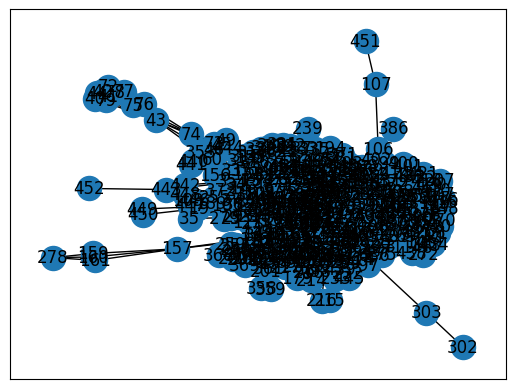

In [19]:
temp = adj_norm_S.coalesce().indices()
print(temp.shape)
print(temp)

G1 = nx.from_edgelist(temp.T.cpu().numpy())
G1.remove_edges_from(nx.selfloop_edges(G1))
print(G1.number_of_nodes(), G1.number_of_edges())

pos = nx.spring_layout(G1)
nx.draw_networkx(G1, pos=pos)

torch.Size([2, 4687])
tensor([[  0,   0,   0,  ..., 452, 452, 452],
        [  0,  11,  64,  ..., 413, 440, 452]], device='cuda:0')
453 2117


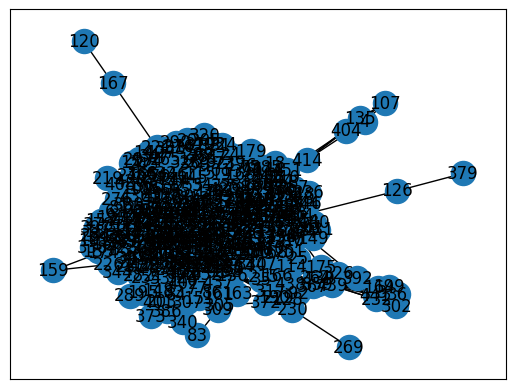

In [20]:
temp = adj_norm_S_hat.coalesce().indices()
print(temp.shape)
print(temp)

G2 = nx.from_edgelist(temp.T.cpu().numpy())
G2.remove_edges_from(nx.selfloop_edges(G2))
print(G2.number_of_nodes(), G2.number_of_edges())

nx.draw_networkx(G2)

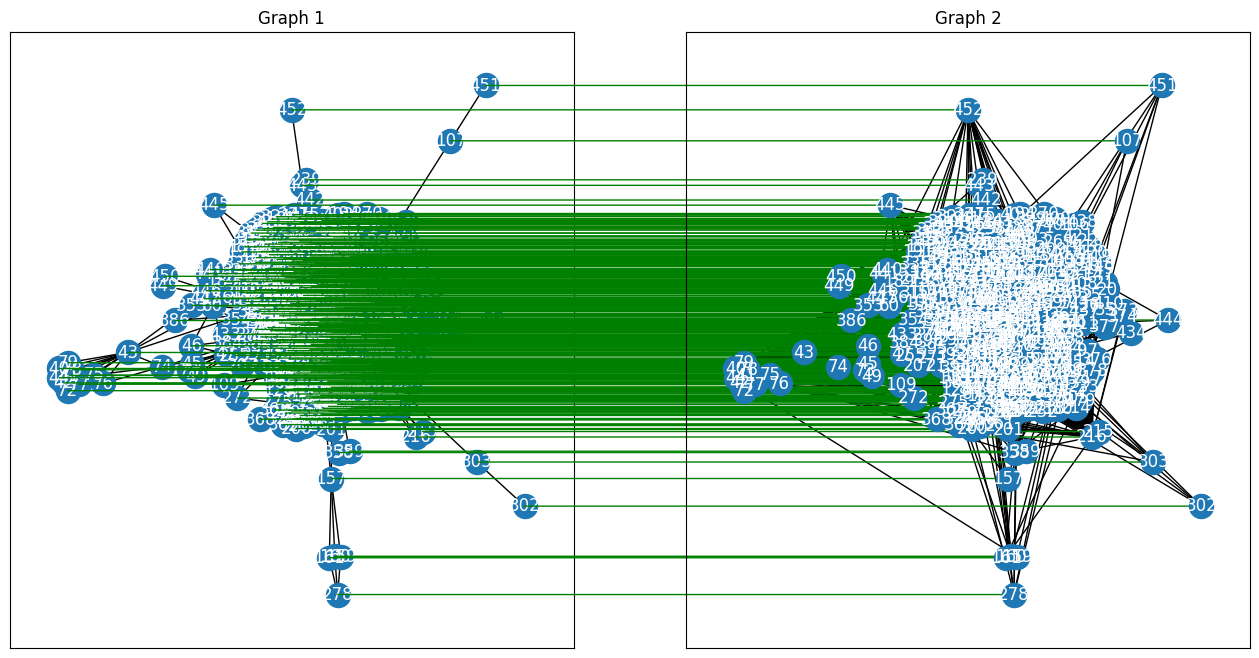

In [21]:
pos1 = nx.spring_layout(G1)
pos2 = nx.spring_layout(G2)

plt.figure(figsize=(16, 8))
ax1 = plt.subplot(1, 2, 1)
plt.title('Graph 1')
nx.draw_networkx(G1, pos=pos1, font_color="w")
ax2 = plt.subplot(1, 2, 2)
plt.title('Graph 2')
nx.draw_networkx(G2, pos=pos1, font_color="w")

# add connections
for i in range(len(pos1)):
    con = ConnectionPatch(xyA=pos1[i], xyB=pos1[i], coordsA=ax1.transData, coordsB=ax2.transData, arrowstyle="-", color="green")
    ax2.add_artist(con)
plt.show()

---

In [ ]:
from munkres import Munkres, print_matrix

matrix = [[5, 9, 1],
          [10, 3, 2],
          [8, 7, 4]]
m = Munkres()
indexes = m.compute(matrix)
print_matrix(matrix, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = matrix[row][column]
    total += value
    print(f'({row}, {column}) -> {value}')
print("total cost: {}".format(total))